# Implement a custom Autoencoder with Koopman layer

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Preprocess Data
3) Make sure sim data is different for different ground parameters
4) Validation data has different batch size. Address when HP training
5) Address semi graident issue for K^m*z in linearity loss

## Setup

In [40]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd

import matplotlib.colors as mcol

import time 
import os

In [41]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [42]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [43]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [44]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',', header=None).values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',', header=None).values
discrete_validation = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',', header=None).values

In [45]:
trajLength = 64 #length of each trajectory in the dataset
numTraj = 1024 #total number of trajectories in the dataset
numTraj_val = 256
batch_size = int(256) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
input_dim = 2

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)

In [46]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_validation = (discrete_validation - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train[0:batch_size*num_batches_train], tf.float32)
validation_data = tf.cast(discrete_validation[0:batch_size*num_batches_val], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(discrete_test, tf.float32)

In [47]:
x_train = train_data
y_train = train_data

tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([65536,     2])>

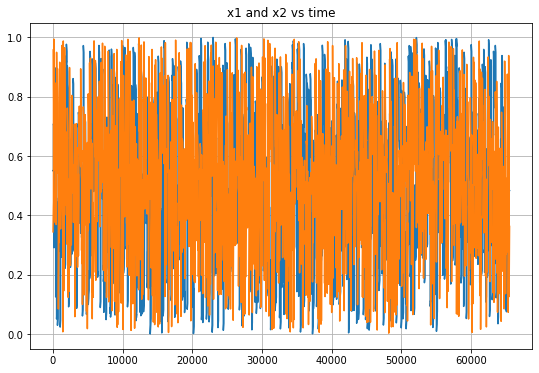

In [48]:
trail = train_data[trajLength*100:trajLength*110,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

# Custom Model definition

## Encoder

In [49]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a encoder layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [50]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None):
        super(EncoderModel, self).__init__(name=name)
        self.enc1 = EncoderLayer(16)
        self.enc2 = EncoderLayer(32)
        self.enc3 = EncoderLayer(64)
        self.enc4 = EncoderLayer(64)
        self.enc_output = EncoderLayer(2)
    def call(self, input):
        x = input
        x = self.enc1(x)
        x = tf.nn.relu(x)
        x = self.enc2(x)
        x = tf.nn.relu(x)
        x = self.enc3(x)
        x = tf.nn.relu(x)
        x = self.enc4(x)
        x = tf.nn.relu(x)

        # Encoder output layer
        z = self.enc_output(x)
        z = tf.nn.relu(z)
        
        return z

## Koopman

In [51]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, latent_dm)
        m is the number of time snapshots for each input dimension of X
        latent_dm is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj_batch):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj_batch = numTraj_batch

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Psi1 = []
        Psi2 = []
        psi0 = []

        for i in range(self.numTraj_batch):
            Psi1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Psi2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            psi0.append(Z[i*self.trajLength,:])
        return tf.reshape(Psi1, [-1, latent_dim]), tf.reshape(Psi2, [-1, latent_dim]), tf.reshape(psi0, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj_batch # length of rows for forward time shifted Z
        Psi1, Psi2, psi0 = self.timeShift(Z,latent_dim)

        # define eigenvalue matrix based on linearization of the orignial system
        self.Lambda = tf.linalg.diag([-1.0, -0.05])

        # Find Z2_tilde
        Psi2_linear = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj_batch): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 indices = tf.constant([[traj*(self.trajLength-1)+m]])
                 if m == 0:
                    Lambda = self.Lambda 
                    # Matrix matvec works out to get Kz' and returns as row vector
                    updates = [tf.linalg.matvec(Lambda, psi0[traj,:])] #updates the row tensor at index = indices 
                    Psi2_linear = tf.tensor_scatter_nd_update(Psi2_linear, indices, updates)
                 else:
                    K = tf.matmul(Lambda,self.Lambda)
                    updates = [tf.linalg.matvec(Lambda, psi0[traj,:])]
                    Psi2_linear = tf.tensor_scatter_nd_update(Psi2_linear, indices, updates)

        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Psi2,Psi2_linear)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, Psi1",tf.shape(Psi1))
        #print("Koopman layer, Psi2 ",tf.shape(Psi2))
        #print("Koopman layer, Psi2_linear",tf.shape(Psi2_linear))
        
        return Z, tf.matmul(Psi1,self.Lambda), Psi2_linear,

In [52]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    
    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    """
    
    def __init__(self, trajLength, numTraj_batch, name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj_batch)


    def call(self, input):
        Psi = input
        Psi, Psi2_hat, Psi2_linear = self.koopman(Psi)
        return Psi, Psi2_hat, Psi2_linear

## Decoder

In [53]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer

    W.T * input3 + b: tensor
        linear combination of weights times input3 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [54]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Prediction of the original state inputs x (label values are forward time shifted x)

    x2_tilde: tensor
        Prediction obtained by linearity from K 
    
    """
    
    def __init__(self, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.dec1 = DecoderLayer(64)
        self.dec2 = DecoderLayer(64)
        self.dec3 = DecoderLayer(32)
        self.dec4 = DecoderLayer(16)
        self.outputLayer = DecoderLayer(2)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        z, z2_hat, z2_tilde = self.dec1(z, z2_hat, z2_tilde)
        z = tf.nn.relu(z)
        z2_hat = tf.nn.relu(z2_hat)
        z2_tilde = tf.nn.relu(z2_tilde)

        z, z2_hat, z2_tilde = self.dec2(z, z2_hat, z2_tilde)
        z = tf.nn.relu(z)
        z2_hat = tf.nn.relu(z2_hat)
        z2_tilde = tf.nn.relu(z2_tilde)

        z, z2_hat, z2_tilde = self.dec3(z, z2_hat, z2_tilde)
        z = tf.nn.relu(z)
        z2_hat = tf.nn.relu(z2_hat)
        z2_tilde = tf.nn.relu(z2_tilde)

        z, z2_hat, z2_tilde = self.dec4(z, z2_hat, z2_tilde)
        z = tf.nn.relu(z)
        z2_hat = tf.nn.relu(z2_hat)
        z2_tilde = tf.nn.relu(z2_tilde)

        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)

        return x_hat, x2_hat, x2_tilde

## Koopman Autoencoder

In [55]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, trajLength, numTraj, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

# Custom Training Loop

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.batch(batch_size)

In [59]:
class MyStaticModel():
    def __init__(self, input_dim, batch_size, trajLength, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 

    ######################################  LOSS FUNCTIONS  ###################################################
    def tot_loss(self, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        #alpha1 = 0.1, alpha2 = 1e-7, alpha3 = 1e-15
        alpha1 = 0.1
        alpha2 = 1e-7
        alpha3 = 1e-15

        #print("In loss function x", tf.shape(x))
        #print("In loss function x_hat", tf.shape(x_hat))
        #print("In loss function x2_hat", tf.shape(x2_hat))
        #print("In loss function x2_tilde", tf.shape(x2_tilde))

        x2 = []
        x2_SP = []
        x2_tilde_SP = []
        for i in range(self.numtraj_batch):
            predict_length = self.trajLength-1
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength]) # forward time shift x to get x2
            x2_SP.append(x[i*self.trajLength+1:i*self.trajLength+predict_length+1]) # forward time shift x to get x2 for Sp timesteps
            #x2_tilde_SP.append(x2_tilde[i*self.trajLength:i*self.trajLength+predict_length]) # get Sp timesteps from x2_tilde
            x2_tilde_SP = x2_tilde

        #print("In loss function x2", tf.shape(x2))
        #print("In loss function x2_SP", tf.shape(x2_SP))
        #print("In loss function x2_tilde_SP", tf.shape(x2_tilde_SP))
        
        x2 = tf.reshape(x2, [-1, x.shape[-1]])
        x2_SP = tf.reshape(x2_SP, [-1, x.shape[-1]])
        x2_tilde_SP = tf.reshape(x2_tilde_SP, [-1, x.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2_SP,x2_tilde_SP)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf), tf.norm(tf.subtract(x2,x2_hat), ord=np.inf))
        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + sum(model.losses)

    ###############################################  GRAPH FUNCTIONS #########################################################

    def graphPlot(self, error, error_min, error_max, error_val, error_min_val, error_max_val):
        '''
        Graph plots for loss over all epochs
        Parameters:
        error: list
            Training Loss Error for all epochs
        error_val: list
            Validation Loss Error for all epochs
        '''
        saveFiles = True
        imgPath = 'graphs/'
        csvPath = 'csvFiles/'

        csvFileName = 'epochLosses.csv'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making graph folder. Folder already exists...")

            try:
                os.mkdir(csvPath)
            except:
                print("Tried making csv folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Training Loss")
        plt.plot(error_val, label = "Validation Loss")
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 
        plt.close()

        # Save data into csv file
        csvDict = {'Epoch Training Loss': error, 'Epoch Training Min Loss': error_min, 'Epoch Training Max Loss': error_max,
                    'Epoch Validation Loss': error_val, 'Epoch Validation Min Loss' : error_min_val, 
                    'Epoch Validation Max Loss': error_max_val}
        df = pd.DataFrame(csvDict)
        df.to_csv(csvPath+csvFileName)

    
    def graphBatchLossPlot(self, epochNum, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Batch Training Loss")
        plt.plot(error_val, label="Batch Validation Loss")
        textTitle = "BatchLoss_Epoch_%d" % (epochNum)
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
        plt.close() 

    
    def graphEigenfunctions(self, model):
        saveFiles = True
        imgPath = 'graphs/eigenfunctions/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        x1 = tf.squeeze(tf.linspace(-1,1,100))
        x2 = tf.squeeze(tf.linspace(-1,1,100))
        x1, x2 = tf.meshgrid(x1, x2)
        X = tf.transpose(tf.reshape(tf.concat([[x1],[x2]],axis=0),[2,-1]))
        Psi = tf.math.real(model.enc(X))   

        eig_values = tf.constant([-1,-0.05])

        for eig in eig_values:
            cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
            normalize = mpl.colors.Normalize(vmin=np.min(Psi[:,0]), vmax=np.max(Psi[:,0]))
            plt.figure(counter)
            fig, axs = plt.subplots(2)
            
            p0 = axs[0].scatter(x1, x2, c=Psi[:,0].numpy(), cmap=cm1)
            fig.colorbar(p0, ax=axs[0])
            fig_title0 = "Psi_%0.04f"%(tf.math.real(eig)) 
            axs[0].set_title(fig_title1)

            p1 = axs[0].scatter(x1, x2, c=Psi[:,1].numpy(), cmap=cm1)
            fig.colorbar(p1, ax=axs[0])
            fig_title1 = "Psi_%0.04f"%(tf.math.real(eig)) 
            axs[0].set_title(fig_title1)

            fig.tight_layout()
            textTitle = "Psi_epoch_%d" % counter 

            if saveFiles:
                plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
            plt.close('all') 

    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 100     
        
        epoch_train_loss = [] 
        epoch_train_min_loss = []
        epoch_train_max_loss = []

        epoch_validation_loss = []
        epoch_validation_min_loss = []
        epoch_validation_max_loss = []


        start_time_total = time.time()
        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            
            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                with tf.GradientTape() as tape:
                    reconstruction, prediction, linearity = model(x_batch_train)

                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, prediction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, pred_val, linearity_val = model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, pred_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))
            #self.graphBatchLossPlot(epoch, batch_train_loss_list, batch_validation_loss_list)
            #K = model.koopman.get_weights()
            self.graphEigenfunctions(model)

        self.graphPlot(epoch_train_loss, epoch_train_min_loss, epoch_train_max_loss, epoch_validation_loss, 
                        epoch_validation_min_loss, epoch_validation_max_loss)
        print("Total time taken: %.2fs" % (time.time() - start_time_total))

In [60]:
Training_class = MyStaticModel(input_dim, batch_size, trajLength, num_batches_train, num_batches_val)
koopmanAEModel = Koopman_AE_Model(trajLength, numTraj_batch, name="Koopman_AE_Model")
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.0394022
Epoch val loss: 0.012036041356623173
Time taken: 94.50s

Start of epoch 1
Average training loss at epoch 1: 0.0115784
Epoch val loss: 0.011145874857902527
Time taken: 188.41s

Start of epoch 2
Average training loss at epoch 2: 0.0112115
Epoch val loss: 0.011154438368976116
Time taken: 283.27s

Start of epoch 3
Average training loss at epoch 3: 0.0111556
Epoch val loss: 0.011088418774306774
Time taken: 378.88s

Start of epoch 4
Average training loss at epoch 4: 0.0110642
Epoch val loss: 0.010976115241646767
Time taken: 473.02s

Start of epoch 5
Average training loss at epoch 5: 0.0109307
Epoch val loss: 0.010828835889697075
Time taken: 567.09s

Start of epoch 6
Average training loss at epoch 6: 0.0107683
Epoch val loss: 0.010657122358679771
Time taken: 660.46s

Start of epoch 7
Average training loss at epoch 7: 0.0105984
Epoch val loss: 0.010497045703232288
Time taken: 754.00s

Start of epoch 8
Average training loss at epoch 

# Plots on Train data

### Reconstruction

In [61]:
input = x_train[batch_size*10:batch_size*11]
out1, out2, out3 = koopmanAEModel(input)

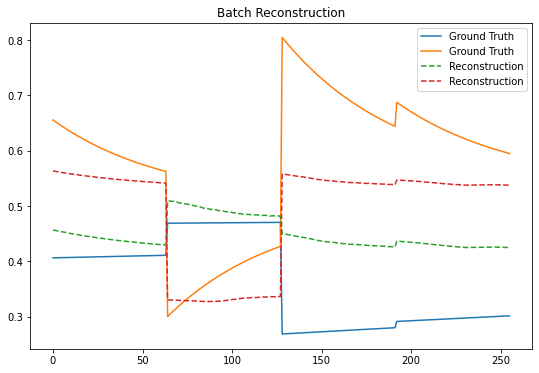

In [62]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(out1, '--', label="Reconstruction")
plt.legend()

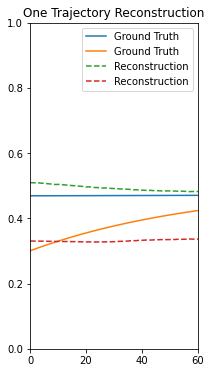

In [63]:
plt.figure(figsize=(3,6))
plt.plot(input[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(out1[trajLength:trajLength*2], '--',label="Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Reconstruction")
plt.legend()

### Linear Prediction

In [64]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

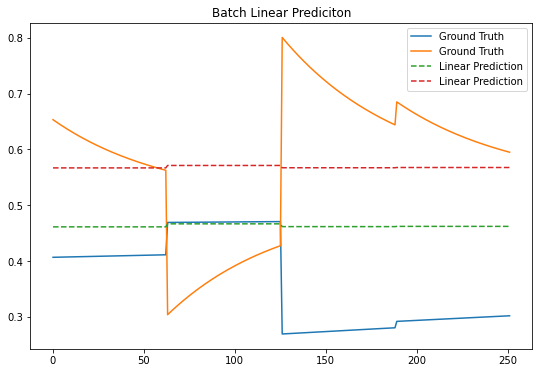

In [65]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2, label = "Ground Truth")
plt.plot(out3, '--', label="Linear Prediction")
plt.legend()

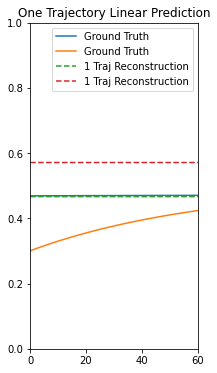

In [66]:
plt.figure(figsize=(3,6))
plt.plot(x[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(out3[trajLength:trajLength*2], '--',label="1 Traj Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Linear Prediction")
plt.legend()

### Error graphs

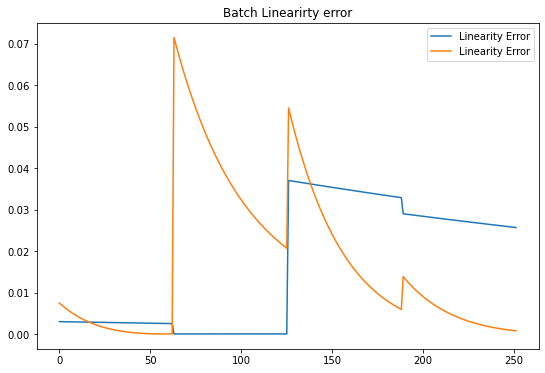

In [67]:
plt.title("Batch Linearirty error")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot((tf.square(tf.subtract(x2,out3))), label = "Linearity Error")
plt.legend()

### Koopman Matrix

In [ ]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[]


# Save the Model

In [ ]:
koopmanAEModel.save('checkpoints/Trained_Model')

INFO:tensorflow:Assets written to: checkpoints/Trained_Model\assets


# Load the Model

In [ ]:
new_model = tf.keras.models.load_model('checkpoints/Trained_Model', compile=False)
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_15 (EncoderMod multiple                  658       
_________________________________________________________________
koopman__model_15 (Koopman_M multiple                  0         
_________________________________________________________________
decoder_model_15 (DecoderMod multiple                  82        
Total params: 740
Trainable params: 740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input = x_train[batch_size*10:batch_size*11]
new_out1, new_out2, new_out3 = new_model(input)

# Plots on Test Data

In [ ]:
input = test_data[batch_size*9:batch_size*10]
new_out1, new_out2, new_out3 = new_model(input)


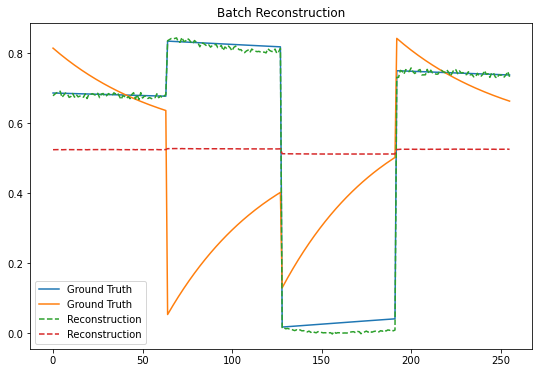

In [ ]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(new_out1, '--', label="Reconstruction")
plt.legend()

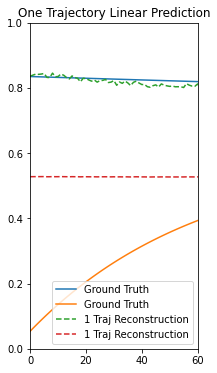

In [ ]:
plt.figure(figsize=(3,6))
plt.plot(input[trajLength:trajLength*2], label = "Ground Truth")
plt.plot(new_out1[trajLength:trajLength*2], '--',label="1 Traj Reconstruction")
plt.axis([0,60,0,1])
plt.title("One Trajectory Linear Prediction")
plt.legend()

In [ ]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

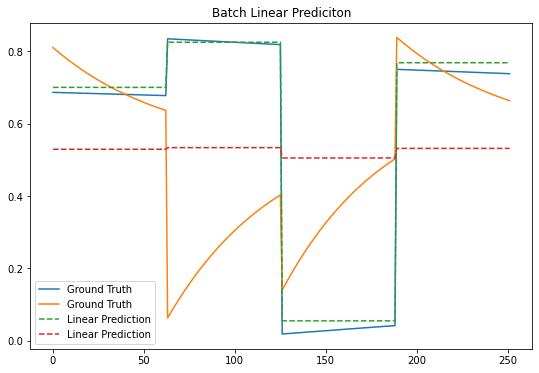

In [ ]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2, label = "Ground Truth")
plt.plot(new_out3, '--', label="Linear Prediction")
plt.legend()

## Plot true eigenfunctions of the system

In [ ]:
K = new_model.koopman.get_weights()
print(tf.squeeze(K))

tf.Tensor([], shape=(0,), dtype=float32)


In [ ]:
x1 = tf.linspace(-1,1,256)
x2 = tf.linspace(-1,1,256)
x1, x2 = tf.meshgrid(x1, x2)
X = tf.reshape([[x1],[x2]], [-1, 2])
print(tf.shape(X))

tf.Tensor([65536     2], shape=(2,), dtype=int32)


In [ ]:
Psi1 = x1
lam = -1
mu = -0.05
b = lam/(lam-2*mu)
Psi2 = tf.Variable(x2 - tf.square(b*x1))

Text(0.5, 1.0, '$\\Psi_\\mu = x_1$')

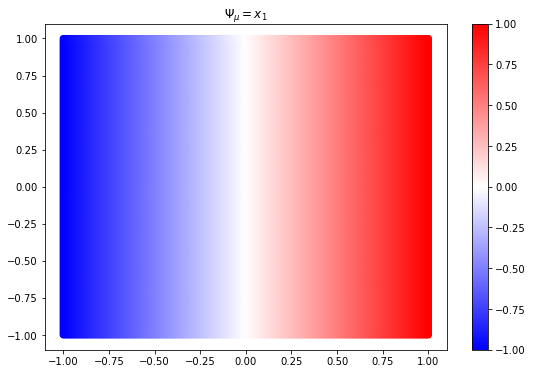

In [ ]:
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
normalize = mpl.colors.Normalize(vmin=np.min(Psi1), vmax=np.max(Psi1))
P1 = plt.scatter(x1, x2, c=Psi1.numpy(), norm=normalize, cmap=cm1)
plt.colorbar(P1)
plt.title('$\Psi_\mu = x_1$')

Text(0.5, 1.0, '$\\Psi_\\lambda = x_2 - bx^2_1$')

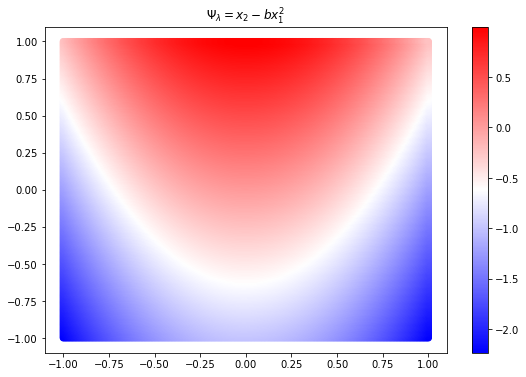

In [ ]:
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
normalize = mpl.colors.Normalize(vmin=np.min(Psi2), vmax=np.max(Psi2))
plt.scatter(x1, x2, c=Psi2.numpy(), norm=normalize, cmap=cm1)
plt.colorbar()
plt.title('$\Psi_\lambda = x_2 - bx^2_1$')

In [ ]:
eig_values, right_eig_vectors = tf.linalg.eig(tf.squeeze(K))
W = tf.transpose(tf.linalg.inv(right_eig_vectors))

eig_dominant = tf.abs(eig_values)
counter = 0
for eig in eig_values:
    cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
    normalize = mpl.colors.Normalize(vmin=np.min(Psi[:,counter]), vmax=np.max(Psi[:,counter]))
    plt.figure(counter)
    plt.scatter(x1, x2, c=Psi[:,counter].numpy(), cmap=cm1)
    #plt.colorbar()
    counter += 1
    #plt.title('$\Psi_$%d',eig)

InvalidArgumentError: Input tensor 0 must have rank >= 2, got 1 [Op:Eig]